In [1]:
import torch
import os
import numpy as np
from torch_geometric.data import Data, DataLoader
from VRP.creat_vrp import reward1,creat_instance
from VRP.VRP_Actor import Model

/Users/mvin/Code/DRL-and-graph-neural-network-for-routing-problems/vrptest/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def rollout(model, dataset,n_nodes):
    model.eval()
    def eval_model_bat(bat):
        with torch.no_grad():
            cost, _ = model(bat, n_nodes * 2,True)
            cost = reward1(bat.x,cost.detach(), n_nodes)
        return cost.cpu()
    totall_cost = torch.cat([eval_model_bat(bat.to(device))for bat in dataset], 0)
    return totall_cost

def evaliuate(valid_loder,n_node):
    folder = 'trained'

    agent = Model(3, 128, 1, 16, conv_laysers=4).to(device)
    agent.to(device)

    filepath = os.path.join(folder, '%s' % n_node)

    if os.path.exists(filepath):
        path1 = os.path.join(filepath, 'actor.pt')
        agent.load_state_dict(torch.load(path1, device))
    cost = rollout(agent, valid_loder, n_node)
    cost = cost.mean()
    print('Problem:VRP''%s' % n_node,'/ Average distance:',cost.item())

    cost1=cost.min()

    return cost,cost1



In [3]:

datas = []
n_node = 21
if n_node==21 or n_node==51 or n_node==101:
    node_ = np.loadtxt('VRP/test_data/vrp{}_test_data.csv'.format(n_node-1), dtype=float, delimiter=',')
    demand_ = np.loadtxt('VRP/test_data/vrp{}_demand.csv'.format(n_node-1), dtype=float, delimiter=',')
    capcity_ = np.loadtxt('VRP/test_data/vrp{}_capcity.csv'.format(n_node-1), dtype=float, delimiter=',')
    batch_size=128
else:
    print('Please enter 21, 51 or 101')
node_ = node_.reshape(-1, n_node, 2)
# Calculate the distance matrix
def c_dist(x1,x2):
    return ((x1[0]-x2[0])**2+(x1[1]-x2[1])**2)**0.5
#edges = torch.zeros(n_nodes,n_nodes)

data_size = node_.shape[0]

edges = np.zeros((data_size, n_node, n_node, 1))
for k, data in enumerate(node_):
    for i, (x1, y1) in enumerate(data):
        for j, (x2, y2) in enumerate(data):
            d = c_dist((x1, y1), (x2, y2))
            edges[k][i][j][0] = d
edges_ = edges.reshape(data_size, -1, 1)



In [4]:
edges_index = []
for i in range(n_node):
    for j in range(n_node):
        edges_index.append([i, j])
edges_index = torch.LongTensor(edges_index)
edges_index = edges_index.transpose(dim0=0, dim1=1)


In [5]:
for i in range(data_size):
    data = Data(x=torch.from_numpy(node_[i]).float(), edge_index=edges_index, edge_attr=torch.from_numpy(edges_[i]).float(),
                demand=torch.tensor(demand_[i]).unsqueeze(-1).float(),
                capcity=torch.tensor(capcity_[i]).unsqueeze(-1).float())
    datas.append(data)

print('Data created')
dl = DataLoader(datas, batch_size=batch_size)
evaliuate(dl,n_node)

Data created


/Users/mvin/Code/DRL-and-graph-neural-network-for-routing-problems/vrptest/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Problem:VRP21 / Average distance: 19.05801773071289


(tensor(19.0580), tensor(19.0580))

### matplotlib

In [44]:
import os
import numpy as np
import torch
from VRP.creat_vrp import reward1

from torch_geometric.data import Data,DataLoader
from VRP.VRP_Actor import Model
from matplotlib import pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_nodes = 21

In [33]:
def discrete_cmap(N, base_cmap=None):
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [48]:
def plot_vehicle_routes(data, route, ax1,Greedy, markersize=5, visualize_demands=False, demand_scale=1, round_demand=False):

    plt.rc('font', family='Times New Roman', size=10)

    routes = [r[r != 0] for r in np.split(route.cpu().numpy(), np.where(route.cpu().numpy() == 0)[0]) if (r != 0).any()]
    depot = data.x[0].cpu().numpy()
    locs = data.x[1:].cpu().numpy()
    demands = data.demand.cpu().numpy()*10
    demands=demands[1:]

    capacity = data.capcity*10

    x_dep, y_dep = depot
    ax1.plot(x_dep, y_dep, 'sk', markersize=markersize * 4)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)

    legend = ax1.legend(loc='upper center')

    cmap = discrete_cmap(len(routes) + 2, 'nipy_spectral')
    dem_rects = []
    used_rects = []
    cap_rects = []
    qvs = []
    total_dist = 0
    for veh_number, r in enumerate(routes):
        color = cmap(len(routes) - veh_number)  # Invert to have in rainbow order

        route_demands = demands[r - 1]
        coords = locs[r - 1, :]
        xs, ys = coords.transpose()

        total_route_demand = sum(route_demands)
        #assert total_route_demand <= capacity
        if not visualize_demands:
            ax1.plot(xs, ys, 'o', mfc=color, markersize=markersize, markeredgewidth=0.0)

        dist = 0
        x_prev, y_prev = x_dep, y_dep
        cum_demand = 0
        for (x, y), d in zip(coords, route_demands):
            dist += np.sqrt((x - x_prev) ** 2 + (y - y_prev) ** 2)

            cap_rects.append(Rectangle((x, y), 0.01, 0.1))
            used_rects.append(Rectangle((x, y), 0.01, 0.1 * total_route_demand / capacity))
            dem_rects.append(Rectangle((x, y + 0.1 * cum_demand / capacity), 0.01, 0.1 * d / capacity))

            x_prev, y_prev = x, y
            cum_demand += d

        dist += np.sqrt((x_dep - x_prev) ** 2 + (y_dep - y_prev) ** 2)
        total_dist += dist
        qv = ax1.quiver(
            xs[:-1],
            ys[:-1],
            xs[1:] - xs[:-1],
            ys[1:] - ys[:-1],
            scale_units='xy',
            angles='xy',
            scale=1,
            color=color,
            label='R{}, N({}), C {} / {}, D {:.2f}'.format(
                veh_number,
                len(r),
                int(total_route_demand) if round_demand else total_route_demand,
                int(capacity) if round_demand else capacity,
                dist
            )
        )

        qvs.append(qv)
    if Greedy:
        ax1.set_title('Greedy,{} routes, total distance {:.2f}'.format(len(routes), total_dist), family='Times New Roman',size=20)
    else:
        ax1.set_title('Sampling1280,{} routes, total distance {:.2f}'.format(len(routes), total_dist), family='Times New Roman',size=20)

    ax1.legend(handles=qvs)
    plt.legend(loc=1)
    pc_cap = PatchCollection(cap_rects, facecolor='whitesmoke', alpha=1.0, edgecolor='lightgray')
    pc_used = PatchCollection(used_rects, facecolor='lightgray', alpha=1.0, edgecolor='lightgray')
    pc_dem = PatchCollection(dem_rects, facecolor='black', alpha=1.0, edgecolor='black')

    if visualize_demands:
        ax1.add_collection(pc_cap)
        ax1.add_collection(pc_used)
        ax1.add_collection(pc_dem)
    plt.show()
    #plt.savefig("./temp{}.png".format(54), dpi=600, bbox_inches='tight')


In [65]:
def vrp_matplotlib(Greedy=True):

    node_ = np.loadtxt('VRP/test_data/vrp20_test_data.csv', dtype=float, delimiter=',')
    demand_=np.loadtxt('VRP/test_data/vrp20_demand.csv', dtype=float, delimiter=',')
    capcity_=np.loadtxt('VRP/test_data/vrp20_capcity.csv', dtype=float, delimiter=',')
    node_,demand_=node_.reshape(-1,n_nodes,2),demand_.reshape(-1,n_nodes)
    data_size = node_.shape[0]

    x=np.random.randint(1,data_size)
    # Calculate the distance matrix
    edges = np.zeros((n_nodes, n_nodes, 1))
    def c_dist(x1, x2):
        return ((x1[0] - x2[0]) ** 2 + (x1[1] - x2[1]) ** 2) ** 0.5
    for i, (x1, y1) in enumerate(node_[x]):
        for j, (x2, y2) in enumerate(node_[x]):
            d = c_dist((x1, y1), (x2, y2))
            edges[i][j][0] = d
    edges_ = edges.reshape(-1, 1)

    edges_index = []
    for i in range(n_nodes):
        for j in range(n_nodes):
            edges_index.append([i, j])
    edges_index = torch.LongTensor(edges_index)
    edges_index = edges_index.transpose(dim0=0, dim1=1)

    datas = []
    data = Data(x=torch.from_numpy(node_[x]).float(), edge_index=edges_index, edge_attr=torch.from_numpy(edges_).float(),
                demand=torch.tensor(demand_[x]).unsqueeze(-1).float(),
                capcity=torch.tensor(capcity_[x]).unsqueeze(-1).float())
    datas.append(data)

    data_loder = DataLoader(datas, batch_size=1)



    agent = Model(3, 128, 1, 16, conv_laysers=4).to(device)
    agent.to(device)
    folder = 'trained'
    filepath = os.path.join(folder, '%s' % n_nodes)

    if os.path.exists(filepath):
        path1 = os.path.join(filepath, 'actor.pt')
        agent.load_state_dict(torch.load(path1, device))
    if Greedy:
        batch = next(iter(data_loder))
        batch.to(device)
        agent.eval()
        #-------------------------------------------------------------------------------------------Greedy
        with torch.no_grad():
            tour, _ = agent(batch, n_nodes * 2,True)
            #cost = reward1(batch.x, tour.detach(), n_nodes)
            #print(cost)
            #print(tour)
    #-------------------------------------------------------------------------------------------sampling1280
    else:
        datas_ = []
        batch_size1 = 128  # sampling batch_size
        for y in range(1280):
            data = Data(x=torch.from_numpy(node_[x]).float(), edge_index=edges_index,
                        edge_attr=torch.from_numpy(edges_).float(),
                        demand=torch.tensor(demand_[x]).unsqueeze(-1).float(),
                        capcity=torch.tensor(capcity_[x]).unsqueeze(-1).float())
            datas_.append(data)
        dl = DataLoader(datas_, batch_size=batch_size1)

        min_tour=[]
        min_cost=100
        T=1.2#Temperature hyperparameters
        for batch in dl:
            with torch.no_grad():
                batch.to(device)
                tour1, _ = agent(batch, n_nodes * 2,False, T)
                cost = reward1(batch.x, tour1.detach(), n_nodes)

                id = np.array(cost.cpu()).argmin()
                m_cost=np.array(cost.cpu()).min()
                tour1=tour1.reshape(batch_size1,-1)
                if m_cost<min_cost:
                    min_cost=m_cost
                    min_tour=tour1[id]

        tour=min_tour.unsqueeze(-2)

    #--------------------------------------------------------------------------------------------
    for i, (data, tour) in enumerate(zip(data_loder, tour)):
        if Greedy:
            print(data.x,data.demand,tour)
            fig, ax = plt.subplots(figsize=(10, 10))
            plot_vehicle_routes(data, tour, ax,Greedy, visualize_demands=False, demand_scale=20, round_demand=True)
        else:
            fig, ax = plt.subplots(figsize=(10, 10))
            plot_vehicle_routes(data, tour, ax,Greedy, visualize_demands=False, demand_scale=50, round_demand=True)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


tensor([[9.2949e-01, 9.8131e-01],
        [4.6923e-02, 2.7353e-01],
        [9.8009e-01, 2.3600e-04],
        [1.8692e-01, 7.5176e-01],
        [5.3451e-01, 2.3965e-01],
        [4.4585e-01, 6.3472e-01],
        [9.0367e-01, 9.2710e-01],
        [9.8124e-01, 3.9362e-01],
        [6.5284e-01, 6.5850e-01],
        [3.5177e-01, 9.6003e-01],
        [7.7084e-01, 9.2473e-01],
        [1.2300e-01, 5.2817e-01],
        [8.7003e-01, 5.4003e-01],
        [7.6245e-01, 7.5990e-01],
        [3.1897e-01, 8.5401e-01],
        [9.9718e-01, 8.6856e-01],
        [8.9812e-01, 7.3057e-01],
        [5.6957e-01, 2.0380e-01],
        [6.2558e-01, 9.3806e-01],
        [7.7209e-01, 1.0165e-01],
        [2.9661e-01, 2.6203e-01]]) tensor([[0.0000],
        [0.8000],
        [0.2000],
        [0.7000],
        [0.5000],
        [0.4000],
        [0.4000],
        [0.9000],
        [0.9000],
        [0.8000],
        [0.2000],
        [0.6000],
        [0.6000],
        [0.9000],
        [0.3000],
        [0.3000

/var/folders/h8/0wmx2zx90bn60jw8zc1r4qjc0000gn/T/ipykernel_931/639031459.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

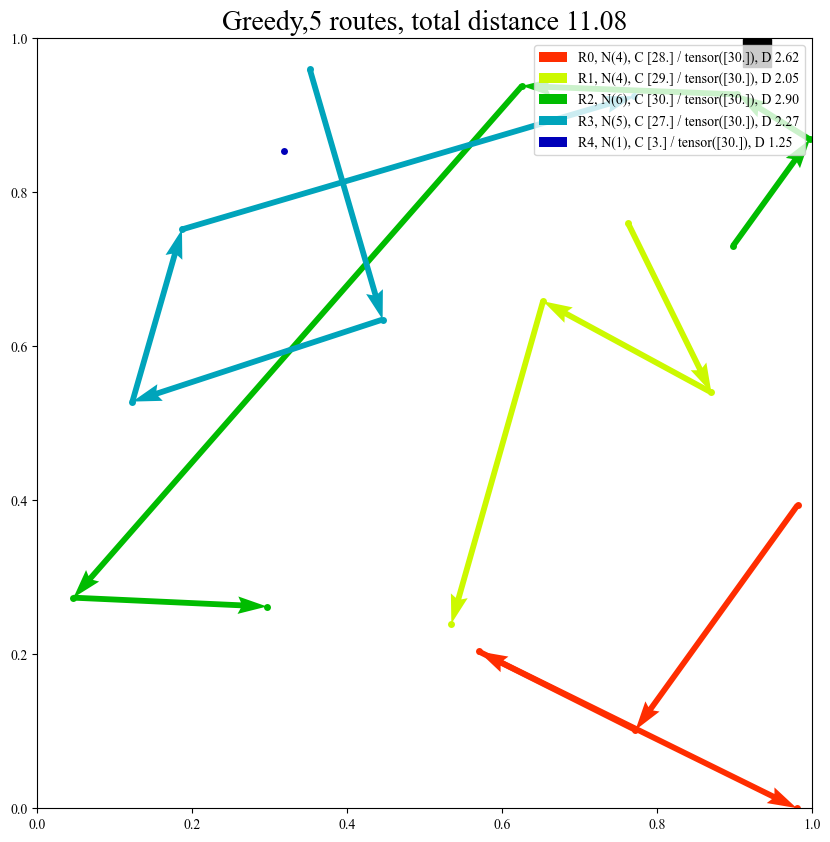

In [71]:

#True:Greedy decoding / False:sampling1280
vrp_matplotlib(Greedy=True)